# Forecast COVID-19 modeling

## 초기 설정

In [1]:
import sys

sys.path.append('..')  # ROOT 디렉토리 path 추가

In [2]:
# 모듈 자동 리로드

%load_ext autoreload
%autoreload 2

In [76]:
# 필요 라이브러리 임포트
import os
from pathlib import Path
from urllib.request import urlopen, Request
from urllib.parse import urlencode, quote_plus

import tensorflow as tf
import pandas as pd
import numpy as np
import xmltodict
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from pytrends import dailydata
from xgboost import XGBRegressor

In [4]:
ROOT = Path(os.getcwd()).parent

## 데이터 수집

In [5]:
# 공공데이터 포털 API key

with open(ROOT / 'datago_key.txt', 'r') as f:
    service_key = f.read()

In [6]:
service_url = 'http://openapi.data.go.kr/openapi/service/rest/Covid19/getCovid19SidoInfStateJson'

query_params = '?' + urlencode({
    quote_plus('ServiceKey'): service_key,
    quote_plus('pageNo'): '1',
    quote_plus('numOfRows'): '10',
    quote_plus('startCreateDt'): '20200303',
    quote_plus('endCreateDt'): '20220220',
})

req = Request(service_url + query_params)
req.get_method = lambda: 'GET'
response = urlopen(req)

In [7]:
# 정상 응답
if response.status == 200:
    response = xmltodict.parse(response.read())['response']
    # 결과가 정상적으로 반환되었을 때
    if response['header']['resultCode'] == '00':
        # 결과 아이템이 존재할 때
        if response['body']['items']:
            covid_data = pd.DataFrame(response['body']['items']['item'])
            covid_data.sort_values(by=['createDt'], ignore_index=True, inplace=True)
            
covid_data

,createDt,deathCnt,defCnt,gubun,gubunCn,gubunEn,incDec,isolClearCnt,localOccCnt,overFlowCnt,qurRate,seq,stdDay,updateDt
0,2020-03-03 09:00:00.000,0,0,검역,隔離區,Lazaretto,0,0,0,0,0.00,818,2020년 03월 03일 00시,2021-09-16 10:11:33.897
1,2020-03-03 09:00:00.000,28,4812,합계,合计,Total,600,34,599,1,9.28,836,2020년 03월 03일 00시,2021-09-16 10:11:33.897
2,2020-03-03 09:00:00.000,0,98,서울,首尔,Seoul,7,13,7,0,1.01,835,2020년 03월 03일 00시,2021-09-16 10:11:33.897
3,2020-03-03 09:00:00.000,0,87,부산,釜山,Busan,2,0,2,0,2.55,834,2020년 03월 03일 00시,2021-09-16 10:11:33.897
4,2020-03-03 09:00:00.000,20,3604,대구,大邱,Daegu,520,2,520,0,147.92,833,2020년 03월 03일 00시,2021-09-16 10:11:33.897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13675,2022-02-20 08:53:21.989,53,35837,전남,全南,Jeollanam-do,2064,6931,2060,4,1936,15224,2022년 02월 20일 00시,null
13676,2022-02-20 08:53:21.989,273,60572,경북,庆北,Gyeongsangbuk-do,3349,19098,3342,7,2295,15225,2022년 02월 20일 00시,null
13677,2022-02-20 08:53:21.989,132,78329,경남,庆南,Gyeongsangnam-do,5093,40611,5087,6,2345,15226,2022년 02월 20일 00시,null
13678,2022-02-20 08:53:21.989,14,16102,제주,济州,Jeju,1231,10083,1231,0,2387,15227,2022년 02월 20일 00시,null


In [7]:
trends_data = dailydata.get_daily_data('선별진료소', 2020, 3, 2022, 2, geo='KR')
trends_data

선별진료소:2020-03-01 2020-03-31
선별진료소:2020-04-01 2020-04-30
선별진료소:2020-05-01 2020-05-31
선별진료소:2020-06-01 2020-06-30
선별진료소:2020-07-01 2020-07-31
선별진료소:2020-08-01 2020-08-31
선별진료소:2020-09-01 2020-09-30
선별진료소:2020-10-01 2020-10-31
선별진료소:2020-11-01 2020-11-30
선별진료소:2020-12-01 2020-12-31
선별진료소:2021-01-01 2021-01-31
선별진료소:2021-02-01 2021-02-28
선별진료소:2021-03-01 2021-03-31
선별진료소:2021-04-01 2021-04-30
선별진료소:2021-05-01 2021-05-31
선별진료소:2021-06-01 2021-06-30
선별진료소:2021-07-01 2021-07-31
선별진료소:2021-08-01 2021-08-31
선별진료소:2021-09-01 2021-09-30
선별진료소:2021-10-01 2021-10-31
선별진료소:2021-11-01 2021-11-30
선별진료소:2021-12-01 2021-12-31
선별진료소:2022-01-01 2022-01-31
선별진료소:2022-02-01 2022-02-28


,선별진료소_unscaled,선별진료소_monthly,isPartial,scale,선별진료소
date,,,,,
2020-03-01,37,12.0,False,0.12,4.44
2020-03-02,100,12.0,NaN,0.12,12.00
2020-03-03,39,12.0,NaN,0.12,4.68
2020-03-04,46,12.0,NaN,0.12,5.52
2020-03-05,27,12.0,NaN,0.12,3.24
...,...,...,...,...,...
2022-02-21,45,61.0,NaN,0.61,27.45
2022-02-22,43,61.0,NaN,0.61,26.23
2022-02-23,36,61.0,NaN,0.61,21.96


In [39]:
for keyword in ['자가격리', '코로나 증상']:
    tmp_df = dailydata.get_daily_data(keyword, 2020, 3, 2022, 2, geo='KR', verbose=False)
    trends_data = pd.concat([trends_data, tmp_df[[keyword + '_unscaled', keyword]]], axis=1)

<AxesSubplot:xlabel='date'>

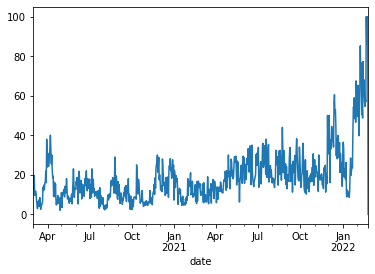

In [45]:
trends_data['자가격리'].plot()

선별진료소


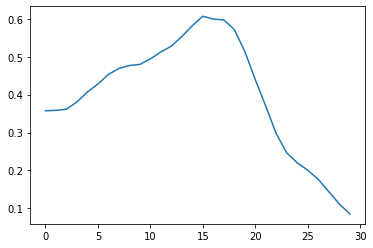

자가격리


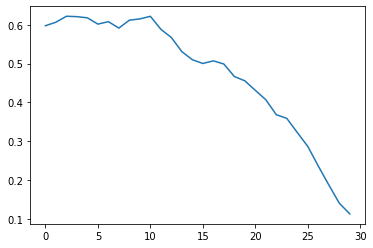

코로나 증상


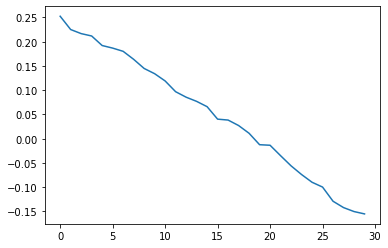

In [51]:
for keyword in ['선별진료소', '자가격리', '코로나 증상']:
    xcorrs = []
    for shift in range(30):
        coef = covid_data[covid_data['gubunEn'] == 'Total']['incDec'].reset_index(drop=True).corr(trends_data[(trends_data.index >= '20200303') 
                    & (trends_data.index <= '20220220')].reset_index()[keyword].shift(shift))
        xcorrs.append(coef)
    print(keyword)
    plt.plot(xcorrs)
    plt.show()    

In [56]:
trends_data[(trends_data.index >= '20200303') 
             & (trends_data.index <= '20220220')].reset_index()[['date',
                                                                 '선별진료소', '선별진료소_unscaled',
                                                                 '자가격리', '자가격리_unscaled']].to_csv(ROOT / 'data/20200303_20220220_trends.csv', index=False)

## 모델링

In [57]:
covid_data = pd.read_csv(ROOT / 'data/20200303_20220220_covid.csv')
trends_data = pd.read_csv(ROOT / 'data/20200303_20220220_trends.csv')

In [58]:
INPUT_LEN = 28
OUTPUT_LEN = 15

In [59]:
trends_data

,date,선별진료소,선별진료소_unscaled,자가격리,자가격리_unscaled
0,2020-03-03,4.68,39,19.76,76
1,2020-03-04,5.52,46,9.62,37
2,2020-03-05,3.24,27,10.66,41
3,2020-03-06,4.92,41,11.70,45
4,2020-03-07,12.00,100,10.14,39
...,...,...,...,...,...
715,2022-02-16,21.24,36,68.04,81
716,2022-02-17,23.01,39,57.96,69
717,2022-02-18,23.01,39,54.60,65
718,2022-02-19,32.45,55,57.96,69


In [63]:
x = trends_data[['선별진료소', '자가격리']].values
y = covid_data[covid_data.gubunEn == 'Total'].incDec.astype('int').values

len(x), len(y)

(720, 720)

In [110]:
x_scaler = MinMaxScaler()
x_scaled = x_scaler.fit_transform(x)

y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1))
y_scaled = y_scaled.reshape(-1)

In [115]:
x_window = []
y_window = []

for i in range(len(x_scaled) - INPUT_LEN - OUTPUT_LEN + 1):
    x_window.append(x_scaled[i:i + INPUT_LEN])
    y_window.append(y_scaled[i + INPUT_LEN:i + INPUT_LEN + OUTPUT_LEN])

x_window = np.array(x_window)
y_window = np.array(y_window)
    
len(x_window), len(y_window)

(678, 678)

In [132]:
train_x, train_y = x_window[:int(len(x_window) * 1)], y_window[:int(len(y_window) * 1)]
test_x, test_y = x_window[int(len(x_window) * 1):], y_window[int(len(y_window) * 1):]
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((678, 28, 2), (678, 15), (0, 28, 2), (0, 15))

In [131]:
train_x, test_x, train_y, test_y = train_test_split(x_window, y_window, test_size=0.2, shuffle=False)
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((542, 28, 2), (542, 15), (136, 28, 2), (136, 15))

In [145]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(256),
    tf.keras.layers.Dense(OUTPUT_LEN)
])

model.compile(loss='mse', optimizer='adam')

In [146]:
model.fit(train_x, train_y, 
          epochs=100, batch_size=32)

Epoch 1/100


2022-02-27 21:21:23.658464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-02-27 21:21:23.792496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 8/22 [=========>....................] - ETA: 0s - loss: 0.0030    

2022-02-27 21:21:23.867407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 1s 26ms/step - loss: 0.0027
Epoch 2/100
22/22 [==============================] - 0s 16ms/step - loss: 0.0022
Epoch 3/100
22/22 [==============================] - 0s 20ms/step - loss: 0.0023
Epoch 4/100
22/22 [==============================] - 0s 17ms/step - loss: 0.0018
Epoch 5/100
22/22 [==============================] - 0s 17ms/step - loss: 0.0018
Epoch 6/100
22/22 [==============================] - 0s 17ms/step - loss: 0.0021
Epoch 7/100
22/22 [==============================] - 0s 17ms/step - loss: 0.0020
Epoch 8/100
22/22 [==============================] - 0s 17ms/step - loss: 0.0016
Epoch 9/100
22/22 [==============================] - 0s 18ms/step - loss: 0.0013
Epoch 10/100
22/22 [==============================] - 0s 17ms/step - loss: 0.0013
Epoch 11/100
22/22 [==============================] - 0s 16ms/step - loss: 0.0028
Epoch 12/100
22/22 [==============================] - 0s 15ms/step - loss: 0.0023
Epoch 13/100
22/22 [=================

In [147]:
preds = model(train_x)
preds.shape

TensorShape([678, 15])

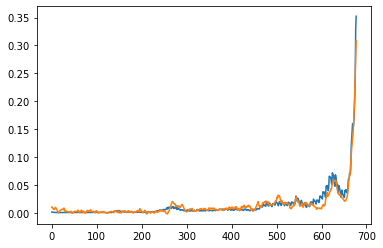

In [148]:
plt.plot(train_y[:, 0])
plt.plot(preds[:, 0])
plt.show()

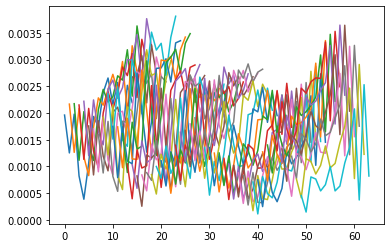

In [128]:
for i, pred in enumerate(preds[:50]):
    plt.plot(range(i, i + OUTPUT_LEN), pred)
plt.show()

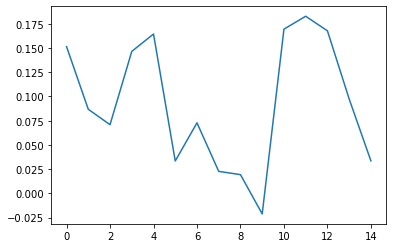

In [149]:
plt.plot(model(x_scaled[-INPUT_LEN:][None])[0])
plt.show()